In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Set two decimal points for display
pd.options.display.float_format = "{:.2f}".format

# Load the Data

In [4]:
armada= pd.read_csv("C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/May 2020 Interim Analysis Data for Manuscripts/ARMADA_TBSCORES_MAY2020.csv")
armada.shape

(1083, 189)

In [5]:
armada.assmnt.value_counts()

1    817
2    266
Name: assmnt, dtype: int64

In [6]:
armada.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,VisualAc_FCTScore,VisualAc_Raw,VisualAc_svalogmar,VisualAc_svasnellen,VisualAc_UCSScore,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,...,60.00,82.00,-0.04,20/16-3,95.00,20.00,18.00,10.00,11.60,2
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1.46421,2,Emory,4,en-US,89,1,1,1,1,...,NaN,76.00,0.08,20/20-4,82.00,0.00,0.00,26.00,26.00,1
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,...,NaN,70.00,0.20,20/30,70.00,7.00,9.00,20.40,18.80,1
4,1.46422,2,Emory,3,en-US,89,2,1,1,1,...,NaN,77.00,0.06,20/20-3,84.00,5.00,8.00,22.00,19.60,1


In [7]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [8]:
#Rename the value under column cohort2
armada['cohort2'] = armada['cohort2'].map(cohort)

In [9]:
armada.cohort2.value_counts()

Gen population 65-85                          266
Gen population MCI                            140
Gen population healthy aging 85+              138
Spanish Speaking normal controls 65-85        130
African American normal controls 65-85        128
Spanish Speaking mild cognitive impairment    125
Gen population AD                              85
African American mild cognitive impairment     46
Spanish Speaking AD                            25
Name: cohort2, dtype: int64

In [10]:
#filter by assmnt = 1
armada = armada[armada.assmnt==1]

In [11]:
edu={1:"None",
2 :"Less than HS",
3 :"Less than HS",
4 :"Less than HS",
5 :"Less than HS",
6 :"Less than HS",
7 :"Less than HS",
8 :"Less than HS",
9 :"Less than HS",
10 :"Less than HS",
11 :"Less than HS",
12 :"Less than HS",
13 :"Less than HS",
14 :"Less than HS",
16 :"High School",
18 :"Some College",
20 :"Some College",
21 :"College Degree",
22 :"Graduate Degree",
23 :"Graduate Degree",
24 :"Graduate Degree",
25 :"Some College",
26 :"Some College",
27 :"Some College",
28 :"None",
999:"Unknown"}

In [12]:
#genpop['EDUCATION'] = genpop['EDUCATION'].map(edu)

# 85 Norm

In [13]:
select = [ 'Gen population 65-85', 'Gen population healthy aging 85+']
genpop = armada[armada.cohort2.isin(select)]

# Raw to Scaled Score (ss) for use in Age-corrected Formulas

##  Adults (18-85 years old) page2


In [14]:
#Raw_to_ScaledScore
cut_bins = [0, 1.55, 2.07, 2.18, 2.43, 3.78, 5.96, 6.68, 7.2, 7.59, 7.90, 8.18, 8.51, 8.76, 9.03, 9.31, 9.65, 9.87, 9.99, 100]
genpop['DCCS_ss'] = pd.cut(genpop['DCCS_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 1.92, 4.18, 4.45, 5.11, 6.24, 6.93, 7.51, 7.9, 8.2, 8.45, 8.75, 8.96, 9.19, 9.4, 9.58, 9.72, 9.87,9.99,100]
genpop['Flanker_ss'] = pd.cut(genpop['Flanker_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 2, 4, 5, 7, 9,11,12,14,15,16,17,18,19,20,21,22,24,25,26]
genpop['LSWM_ss'] = pd.cut(genpop['LSWM_Raw'], bins=cut_bins, labels=list(range(19)))

In [15]:
cut_bins = [200, 217.6, 257.35, 293.24, 303.79, 333.22, 352.61, 382.38, 415.59, 442.62, 481.43, 521.53, 552.56, 599.04, 625.89, 653.76, 677.94, 689.94, 700.89, 722.27, 778.57,800.00]
genpop['PSM_ss'] = pd.cut(genpop['PSM_CScore'], bins=cut_bins, labels=list(range(21)))

In [16]:
cut_bins = [0,16,24,27,29,33,38,42,46,49,53,57,61,64,68,72,75,78,81,84,97,130]
genpop['PCPS_ss'] = pd.cut(genpop['PCPS_CScore'], bins=cut_bins, labels=list(range(21)))

In [17]:
cut_bins = [-30,-12.19,-4.75,-3.69,-1.97,-1.05,-0.01,1.07,2.14,3.03,3.96,4.84,5.73,6.81,7.56,8.23,8.84,9.16,9.35,9.97,16.36,20.00]
genpop['ORR_ss'] = pd.cut(genpop['ORR_Theta'], bins=cut_bins, labels=list(range(21)))

In [18]:
cut_bins = [-15,-10.25,-4.78,-2.94,-0.84,0.46,1.39,2.18,3,3.74,4.42,4.95,5.57,6.25,7.15,7.95,8.77,9.57,9.92,10.62,12.73,15]
genpop['TPVT_ss'] = pd.cut(genpop['TPVT_Theta'], bins=cut_bins, labels=list(range(21)))

# Appendix 2.2 Scaled Scores to Age-corrected scores

In [19]:
#DCCS
def DAge_correct(ss, age):
    rv =100 + 15 * ((ss-(14.82-9.83*(age/100)))/(2.17-0.62*(age/100)))/1.29
    return rv

In [20]:
genpop['DCCS_AC'] = genpop.apply(lambda x: DAge_correct(x.DCCS_ss, x.AGE), axis=1)

In [21]:
genpop['DCCS_AC']=genpop['DCCS_AC'].clip(54, 146)

In [22]:
genpop['DCCS_Diff']=genpop['DCCS_ACSScore']-genpop['DCCS_AC']

In [23]:
genpop[genpop.DCCS_Diff>1][['ptid','site','AGE','DCCS_AC','DCCS_ACSScore','DCCS_Diff']]

,ptid,site,AGE,DCCS_AC,DCCS_ACSScore,DCCS_Diff
716,UM00001250,UMich,70,93.71,98.00,4.29
761,UM00001437,UMich,76,146.00,152.00,6.00


In [24]:
#Flanker
def FAge_correct(ss, age):
    rv =100 + 15 * ((ss-(14.38-8.92*(age/100)))/(2.28-0.63*(age/100)))/1.28
    return rv

In [25]:
genpop['Flanker_AC'] = genpop.apply(lambda x: FAge_correct(x.Flanker_ss, x.AGE), axis=1)

In [26]:
genpop['Flanker_AC']=genpop['Flanker_AC'].clip(54, 146)

In [27]:
genpop['Flanker_Diff']=genpop['Flanker_ACSScore']-genpop['Flanker_AC']

In [28]:
genpop[genpop.Flanker_Diff>1][['ptid','site','AGE','Flanker_AC','Flanker_ACSScore','Flanker_Diff']]

,ptid,site,AGE,Flanker_AC,Flanker_ACSScore,Flanker_Diff
716,UM00001250,UMich,70,86.39,90.00,3.61


In [29]:
#List Sort
def LAge_correct(ss, age):
    rv =100 + 15 *((ss-(11.98-7.37*(age/100)**2))/(2.36-0.34*(age/100)))/1.23
    return rv

In [30]:
genpop['LSWM_AC'] = genpop.apply(lambda x: FAge_correct(x.LSWM_ss, x.AGE), axis=1)

In [31]:
genpop['LSWM_AC']=genpop['LSWM_AC'].clip(54, 146)

In [32]:
genpop['LSWM_Diff']=genpop['LSWM_ACSScore']-genpop['LSWM_AC']

In [33]:
genpop[genpop.LSWM_Diff>1][['ptid','site','AGE','LSWM_AC','LSWM_ACSScore','LSWM_Diff']]

,ptid,site,AGE,LSWM_AC,LSWM_ACSScore,LSWM_Diff
67,101151479,Mayo,80,91.79,93.00,1.21
81,15827182,Mayo,83,80.15,83.00,2.85
185,2274,NU,85,87.92,90.00,2.08
219,3487,UCSD,84,87.37,90.00,2.63
378,94-1666,Mass,70,146.00,155.00,9.00
458,ADRC00208,UWisc,81,79.11,82.00,2.89
536,ADRC00907,UWisc,72,74.61,76.00,1.39
716,UM00001250,UMich,70,105.51,107.00,1.49
747,UM00001407,UMich,85,94.64,96.00,1.36
822,UM00001679,UMich,83,86.82,89.00,2.18


In [34]:
armada[['CTC_ACSScore','CCC_ACSScore', 'CFC_ACSScore']].describe()

,CTC_ACSScore,CCC_ACSScore,CFC_ACSScore
count,584.00,683.00,585.00
mean,101.16,109.01,93.30
std,14.87,14.59,16.40
min,60.00,68.00,43.00
25%,91.00,100.00,81.00
50%,102.00,110.00,93.00
75%,112.00,119.50,104.00
max,139.00,146.00,144.00


In [35]:
#Picture Sequence Memory
def PSMAge_correct(ss, age):
    rv =100 + 15*((ss-(14.06-8.48*(age/100)))/(2.43-0.72*(age/100)))/1.25
    return rv

In [36]:
genpop['PSM_AC'] = genpop.apply(lambda x: PSMAge_correct(x.PSM_ss, x.AGE), axis=1)

In [37]:
genpop['PSM_AC']=genpop['PSM_AC'].clip(54, 146)

In [38]:
genpop['PSM_Diff']=genpop['PSM_ACSScore']-genpop['PSM_AC']

In [39]:
genpop[genpop.PSM_Diff>1][['ptid','site','AGE' ,'PSM_AC','PSM_ACSScore','PSM_Diff']]

,ptid,site,AGE,PSM_AC,PSM_ACSScore,PSM_Diff
195,304325,Mass,78,146.00,149.00,3.00
716,UM00001250,UMich,70,80.54,83.00,2.46


In [40]:
#Pattern comparison
def PCAge_correct(ss, age):
    rv =100 + 15 *((ss-(14.68-9.62*(age/100)))/(2.33-0.74*(age/100)))/1.24
    return rv

In [41]:
genpop['PCPS_AC'] = genpop.apply(lambda x: PCAge_correct(x.PCPS_ss, x.AGE), axis=1)

In [42]:
genpop['PCPS_AC']=genpop['PCPS_AC'].clip(54, 146)

In [43]:
genpop['PCPS_Diff']=genpop['PCPS_ACSScore']-genpop['PCPS_AC']

In [44]:
#Oral Reading
def OAge_correct(ss, age):
    rv =100 + 15 * ((ss-(9.68+0.65*(age/100)))/(1.81+1.19*(age/100)))/1.26
    return rv

In [45]:
genpop['ORR_AC'] = genpop.apply(lambda x: OAge_correct(x.ORR_ss, x.AGE), axis=1)

In [46]:
genpop['ORR_AC']=genpop['ORR_AC'].clip(54, 146)

In [47]:
genpop['ORR_Diff']=genpop['ORR_ACSScore']-genpop['ORR_AC']

In [48]:
#Pic Vocabulary
def PVAge_correct(ss, age):
    rv =100 + 15 * ((ss-(11.41-0.57*(age/100)**(-1)))/(1.86+1.12*(age/100)))/1.24
    return rv

In [49]:
genpop['TPVT_AC'] = genpop.apply(lambda x: OAge_correct(x.TPVT_ss, x.AGE), axis=1)

In [50]:
genpop['TPVT_AC']=genpop['TPVT_AC'].clip(54, 146)

In [51]:
genpop['TPVT_Diff']=genpop['TPVT_ACSScore']-genpop['TPVT_AC']

In [52]:
#Fluid Composite
#[((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Age-corrected Standard Scores) 
#– 100.15) / 10.10] 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 100+ 15*(avg-100.15)/10.10
    return rv
    

In [53]:
genpop['CFC_AC'] = genpop.apply(lambda x: Fluid_composite(x.DCCS_AC, x.Flanker_AC, x.LSWM_AC, x.PSM_AC, x.PCPS_AC), axis=1)

In [54]:
genpop['CFC_Diff']=genpop['CFC_ACSScore']-genpop['CFC_AC']

In [55]:
genpop[['CFC_ACSScore','CFC_AC','CFC_Diff']]

,CFC_ACSScore,CFC_AC,CFC_Diff
13,93.00,93.75,-0.75
17,86.00,86.56,-0.56
19,NaN,111.39,NaN
25,NaN,91.72,NaN
37,NaN,94.50,NaN
...,...,...,...
812,96.00,96.51,-0.51
813,106.00,106.18,-0.18
817,106.00,106.51,-0.51
822,94.00,93.32,0.68


In [56]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.18)/13.64
    return rv

In [57]:
genpop['CCC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.ORR_AC, x.TPVT_AC), axis=1)

In [58]:
genpop['CCC_Diff']=genpop['CCC_ACSScore']-genpop['CCC_AC']

In [59]:
genpop[['CCC_ACSScore','CCC_AC','CCC_Diff']]

,CCC_ACSScore,CCC_AC,CCC_Diff
13,101.00,101.69,-0.69
17,120.00,120.91,-0.91
19,NaN,114.41,NaN
25,NaN,107.94,NaN
37,NaN,103.27,NaN
...,...,...,...
812,108.00,109.11,-1.11
813,125.00,126.23,-1.23
817,115.00,115.84,-0.84
822,117.00,117.49,-0.49


In [60]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.02)/12.93
    return rv

In [61]:
genpop['CTC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.CCC_AC, x.CFC_AC), axis=1)

In [62]:
genpop['CTC_Diff']=genpop['CTC_ACSScore']-genpop['CTC_AC']

In [63]:
genpop[['CTC_AC','CTC_ACSScore','CTC_Diff']]

,CTC_AC,CTC_ACSScore,CTC_Diff
13,97.29,96.00,-1.29
17,103.91,103.00,-0.91
19,113.99,NaN,NaN
25,99.61,NaN,NaN
37,98.58,NaN,NaN
...,...,...,...
812,102.89,103.00,0.11
813,117.62,118.00,0.38
817,112.09,112.00,-0.09
822,105.75,106.00,0.25


In [64]:
select=['ptid', 'assmnt', 'cohort2','EDUCATION','gender_rc','AGE','ethnicity_rc',
 'CCC_ACSScore',
 'CFC_ACSScore',
 'CTC_ACSScore',
 'DCCS_ACSScore',
 'Flanker_ACSScore',
 'LSWM_ACSScore',
 'ORR_ACSScore',
 'PCPS_ACSScore',
 'PSM_ACSScore',
 'TPVT_ACSScore',
 'DCCS_ss',
 'Flanker_ss',
 'LSWM_ss',
 'PSM_ss',
 'PCPS_ss',
 'ORR_ss',
 'TPVT_ss',
 'DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC',
'DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff']

In [65]:
measures =['DCCS',
 'Flanker',
 'LSWM',
 'PSM',
 'PCPS',
 'ORR',
 'TPVT']

In [66]:
def process(df, col):
    diff = col+'_Diff'
    AC = col+'_AC'
    ACSS = col+'_ACSScore'
    
    data = df[df[diff]>1][['ptid','site','AGE',AC, ACSS,diff]]
    data['meas'] = col
    data.columns = ['ptid','site','AGE','AC', 'ACSScore','diff','meas']
    
    return data

In [67]:
rv = []
for col in measures:
    data =process(genpop, col)
    display(data)
    rv.append(data)
    
g1= pd.concat(rv)

,ptid,site,AGE,AC,ACSScore,diff,meas
716,UM00001250,UMich,70,93.71,98.00,4.29,DCCS
761,UM00001437,UMich,76,146.00,152.00,6.00,DCCS


,ptid,site,AGE,AC,ACSScore,diff,meas
716,UM00001250,UMich,70,86.39,90.00,3.61,Flanker


,ptid,site,AGE,AC,ACSScore,diff,meas
67,101151479,Mayo,80,91.79,93.00,1.21,LSWM
81,15827182,Mayo,83,80.15,83.00,2.85,LSWM
185,2274,NU,85,87.92,90.00,2.08,LSWM
219,3487,UCSD,84,87.37,90.00,2.63,LSWM
378,94-1666,Mass,70,146.00,155.00,9.00,LSWM
458,ADRC00208,UWisc,81,79.11,82.00,2.89,LSWM
536,ADRC00907,UWisc,72,74.61,76.00,1.39,LSWM
716,UM00001250,UMich,70,105.51,107.00,1.49,LSWM
747,UM00001407,UMich,85,94.64,96.00,1.36,LSWM
822,UM00001679,UMich,83,86.82,89.00,2.18,LSWM


,ptid,site,AGE,AC,ACSScore,diff,meas
195,304325,Mass,78,146.00,149.00,3.00,PSM
716,UM00001250,UMich,70,80.54,83.00,2.46,PSM


,ptid,site,AGE,AC,ACSScore,diff,meas
716,UM00001250,UMich,70,66.98,70.00,3.02,PCPS


,ptid,site,AGE,AC,ACSScore,diff,meas


,ptid,site,AGE,AC,ACSScore,diff,meas


In [68]:
g1.to_csv('C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/85 Norms/inconsistencies.csv', index=False)

In [69]:
cd=['DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff']

# Hist, Scatter plot

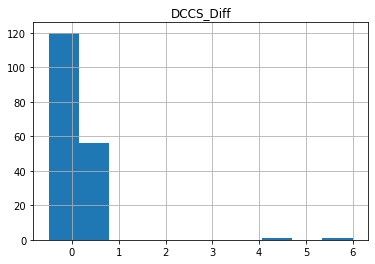

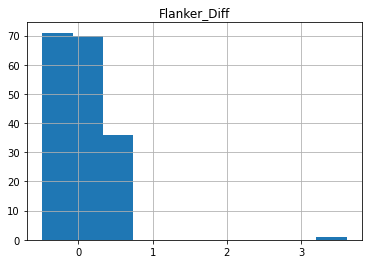

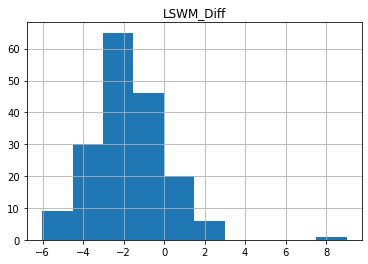

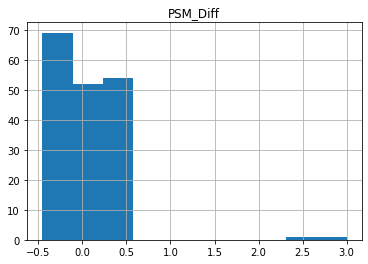

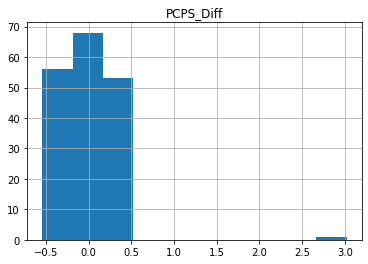

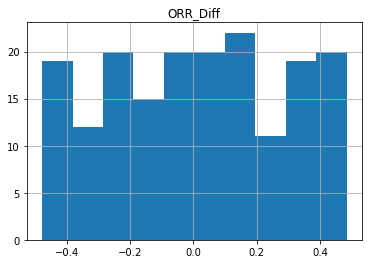

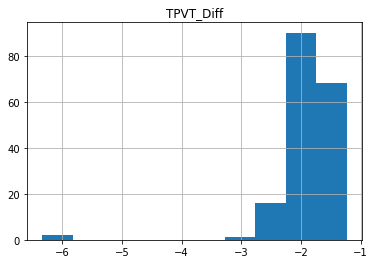

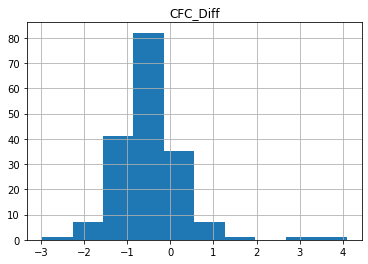

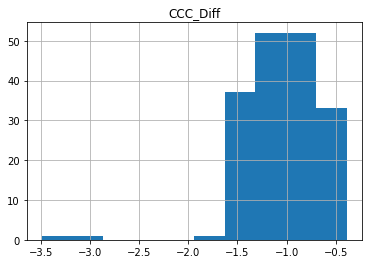

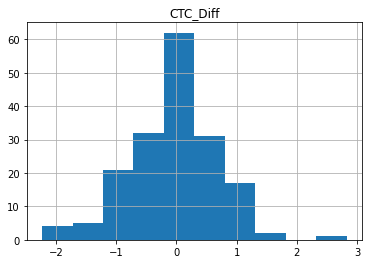

In [70]:
for diff in cd:
    genpop.hist(column=diff)

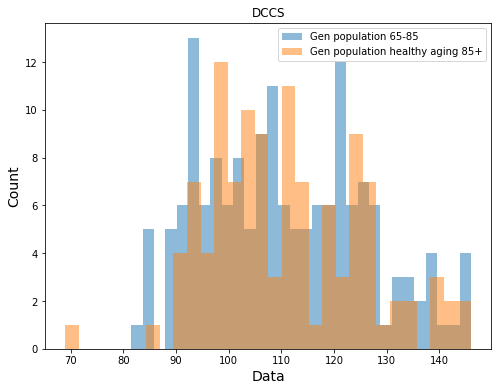

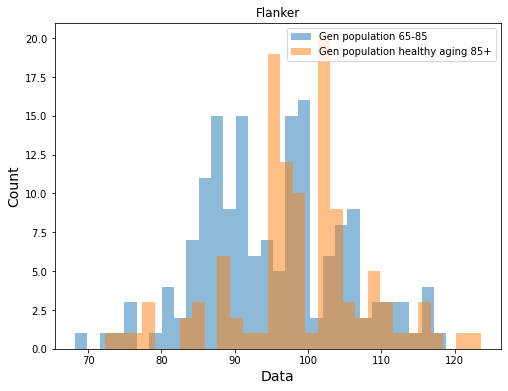

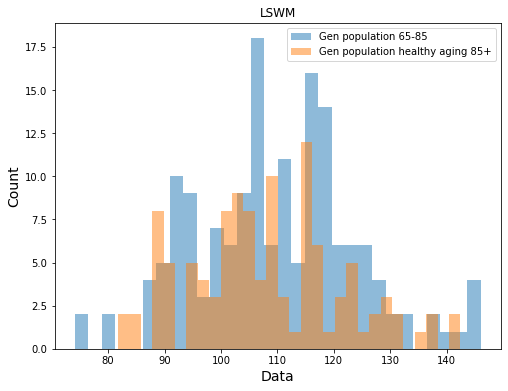

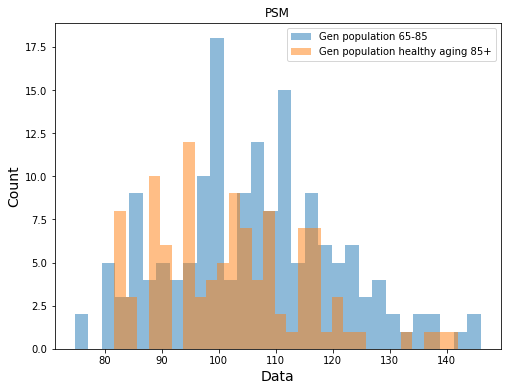

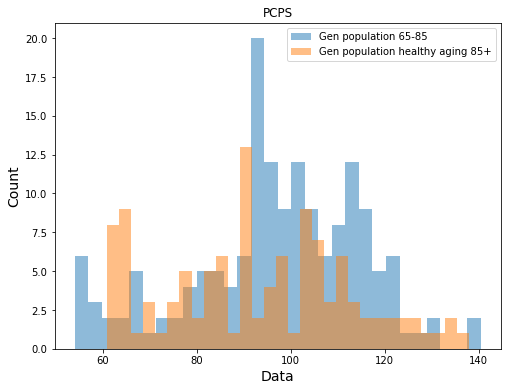

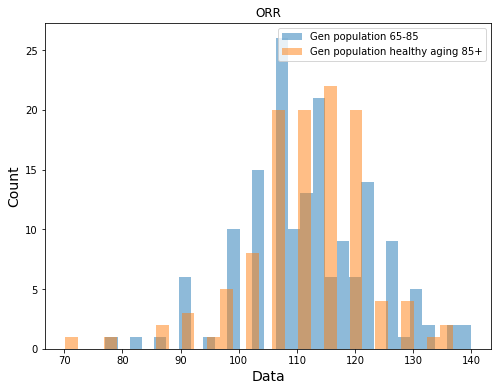

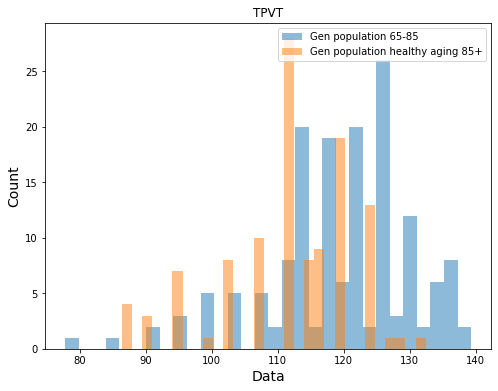

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

for col in measures:
    AC = col+'_AC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85']
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+']
    plt.figure(figsize=(8,6))
    plt.hist(g1[AC], bins=30, alpha=0.5, label='Gen population 65-85')
    plt.hist(g2[AC], bins=30, alpha=0.5, label= 'Gen population healthy aging 85+')
    plt.xlabel('Data', size=14)
    plt.ylabel('Count', size=14)
    plt.title(col)
    plt.legend(loc='upper right')

    

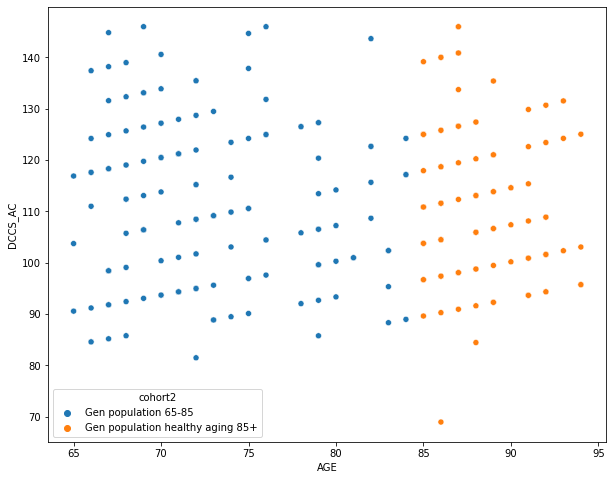

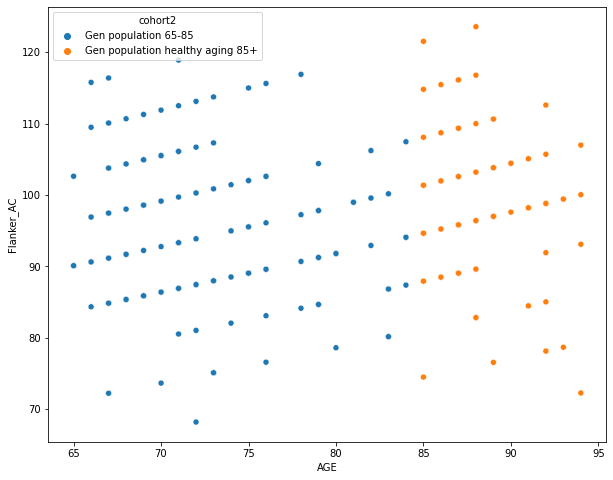

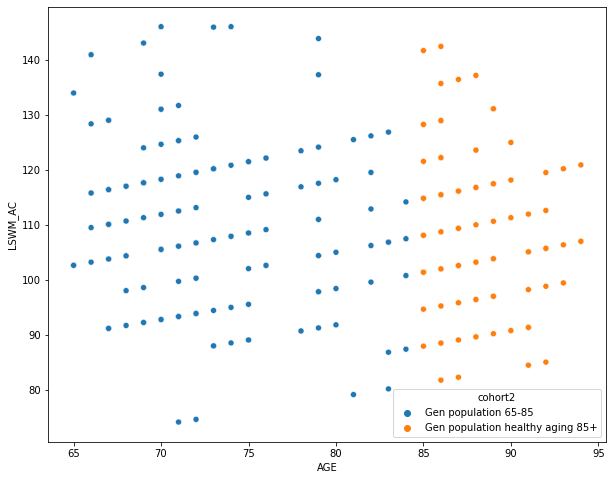

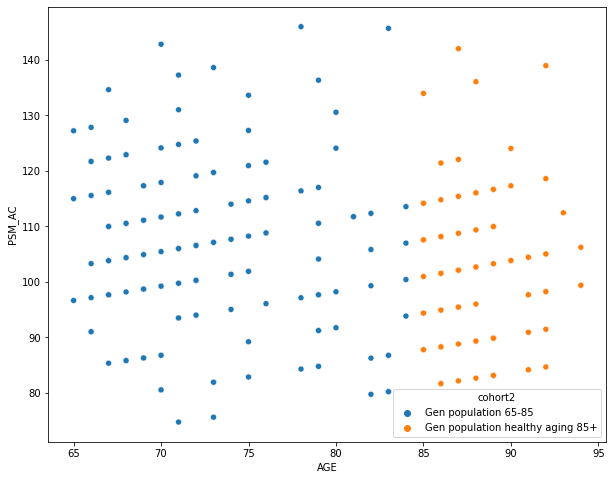

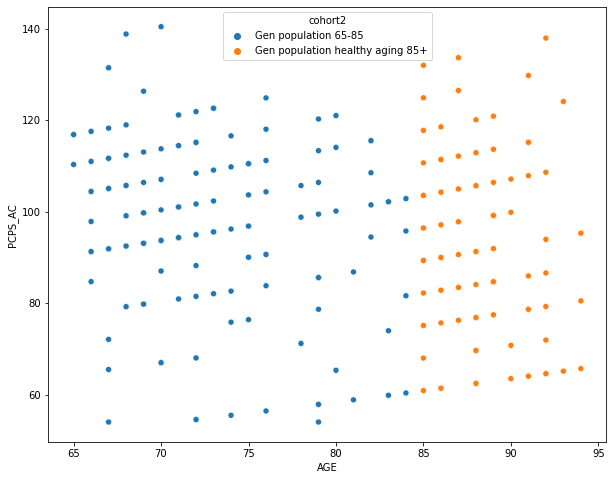

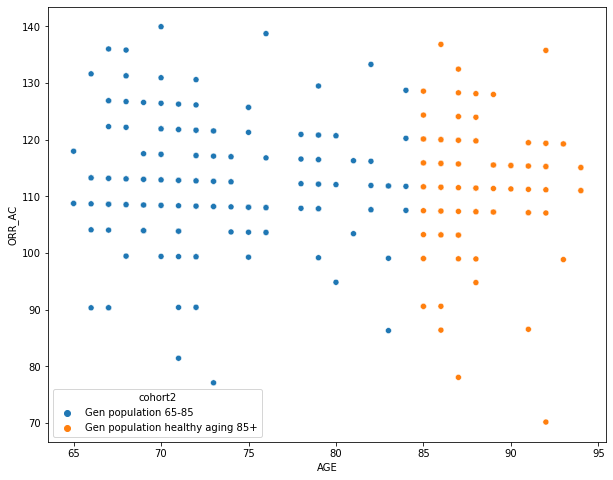

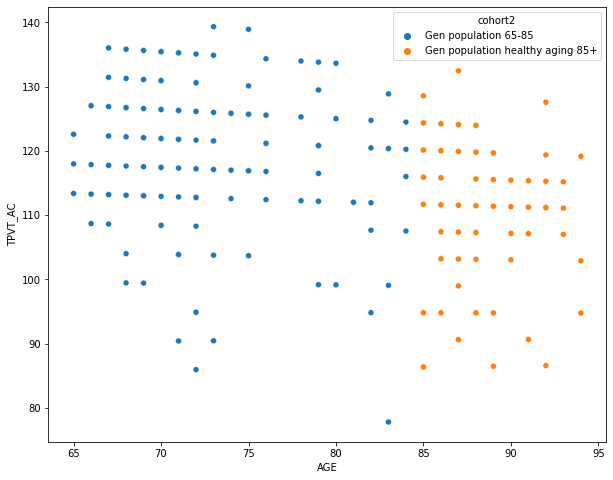

In [72]:
import seaborn as sns
for col in measures:
    plt.figure(figsize=(10,8))
    AC = col+'_AC'
    sns.scatterplot(x="AGE",  y=AC, hue='cohort2', data=genpop)

In [77]:
import numpy as np
import scipy.stats as stats
for col in measures:
    AC = col+'_AC'
    g1 = genpop[genpop.cohort2=='Gen population 65-85'][AC]
    g2 = genpop[genpop.cohort2=='Gen population healthy aging 85+'][AC]
    print(col, 't-stat = %6.2f, pvalue = %6.2f' % stats.ttest_ind(g1.dropna(), g2.dropna(), equal_var=False))
    print('')

DCCS t-stat =  -0.11, pvalue =   0.91

Flanker t-stat =  -3.03, pvalue =   0.00

LSWM t-stat =   0.94, pvalue =   0.35

PSM t-stat =   2.20, pvalue =   0.03

PCPS t-stat =   1.65, pvalue =   0.10

ORR t-stat =   0.45, pvalue =   0.65

TPVT t-stat =   5.76, pvalue =   0.00



In [78]:
genpop[select].to_csv('C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/85 Norms/age_corrected_data.csv', index=False)